## Ishihara vision test plates 
### 1. Generate sample test 
### 2. Segment sample via K-Means clustering

Inspired from the work done by [franciscouzo](https://franciscouzo.github.io)

In [1]:
import math
import random
import numpy as np
import sys
import os
import glob
from PIL import Image, ImageDraw
from tqdm import tqdm
from scipy.spatial import cKDTree as KDTree

TOTAL_CIRCLES = 1500
BACKGROUND = (255, 255, 255)
COLORS_ON = [
    (249, 187, 130), (235, 161, 112), (252, 205, 132)
]
COLORS_OFF = [
    (156, 165, 148), (172, 180, 165), (187, 185, 100),
    (215, 218, 170), (229, 213, 125), (209, 214, 175)
] 

In [2]:
def generate_circle(image_width, image_height, min_diameter, max_diameter):
    radius = random.triangular(min_diameter, 
                               max_diameter,
                               max_diameter * 0.8 + min_diameter * 0.2) / 2

    angle = random.uniform(0, math.pi * 2)
    distance_from_center = random.uniform(0, image_width * 0.48 - radius)
    x = image_width  * 0.5 + math.cos(angle) * distance_from_center
    y = image_height * 0.5 + math.sin(angle) * distance_from_center
    return x, y, radius


def overlaps_motive(image, circle):
    x, y, r = circle[0], circle[1], circle[2]
    # Boundary violation 
    vb = .90
    points_x = [x, x, x, x-r, x+r, x-r*vb, x-r*vb, x+r*vb, x+r*vb]
    points_y = [y, y-r, y+r, y, y, y+r*vb, y-r*vb, y+r*vb, y-r*vb]

    for x, y in zip(points_x, points_y):
        if image.getpixel((x,y))[:3] != BACKGROUND:
            return True
    return False


def circle_intersection(circl_1, circl_2):
    x1, y1, r1 = circl_1[0], circl_1[1], circl_1[2]
    x2, y2, r2 = circl_2[0], circl_2[1], circl_2[2]
    return (x2 - x1)**2 + (y2 - y1)**2 < (r2 + r1)**2


def circle_draw(draw_image, image, circle):
    x, y, r = circle[0], circle[1], circle[2]
    fill_colors = COLORS_ON if overlaps_motive(image, (x, y, r)) else COLORS_OFF
    fill_color = random.choice(fill_colors)
    draw_image.ellipse((x - r, y - r, x + r, y + r), fill=fill_color, outline=fill_color)
    
    

In [3]:
def generate_ish(path):
    fname = path.split("/")[-1].split("-")[0]
    img_in = Image.open(path)
    img_out = Image.new('RGB', img_in.size, BACKGROUND)
    draw_image = ImageDraw.Draw(img_out)
    width, height = img_in.size
    min_diameter = (width + height) / 200
    max_diameter = (width + height) / 75

    # Create circle 
    circle = generate_circle(width, height, min_diameter, max_diameter)
    circles = [circle]

    circle_draw(draw_image, img_in, circle)

    for i in tqdm(range(TOTAL_CIRCLES)):
        tries = 0
        kdtree = KDTree([(x, y) for (x, y, _) in circles])
        while True:
            circle = generate_circle(width, height, min_diameter, max_diameter)
            elements, indexes = kdtree.query([(circle[0], circle[1])], k=4)
            for element, index in zip(elements[0], indexes[0]):
                if not np.isinf(element) and circle_intersection(circle, circles[index]):
                    break
            else:
                break
            tries += 1

        circles.append(circle)
        circle_draw(draw_image, img_in, circle)

#     img_out.show()
    out_path = path.split('/')[:-1]
    img_out.save(f"{os.path.join(*out_path, fname + '-out.png')}", "PNG")

In [4]:
def visualize(image_file, test_file):
    f, ax = plt.subplots(1, 2, figsize=(14, 12))
    ax[0].imshow(image_file)
    ax[0].set_title('')
    ax[0].grid(False)
    ax[0].axes.xaxis.set_visible(False)
    ax[0].axes.yaxis.set_visible(False)
    plt.grid(False)

    ax[1].imshow(test_file)
    ax[1].set_title('')
    ax[1].grid(False)
    ax[1].axes.xaxis.set_visible(False)
    ax[1].axes.yaxis.set_visible(False)
    plt.grid(False)

100%|██████████| 1500/1500 [00:08<00:00, 185.61it/s]


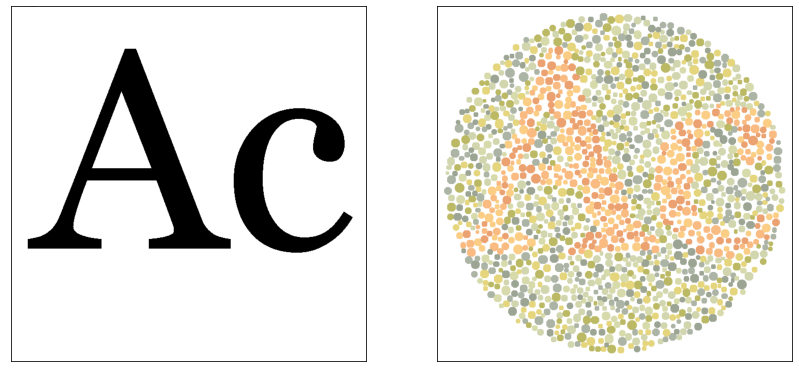

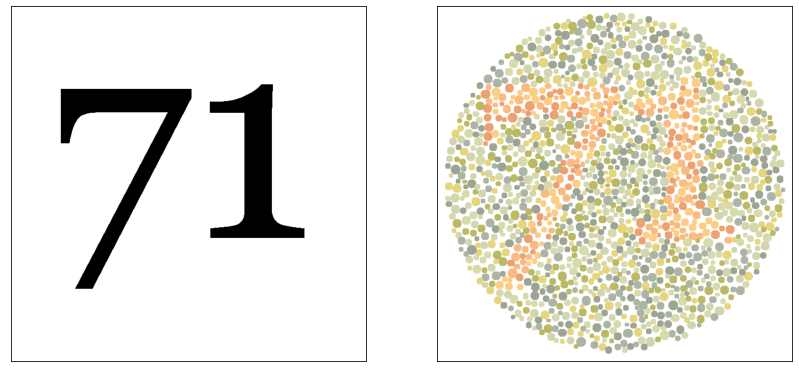

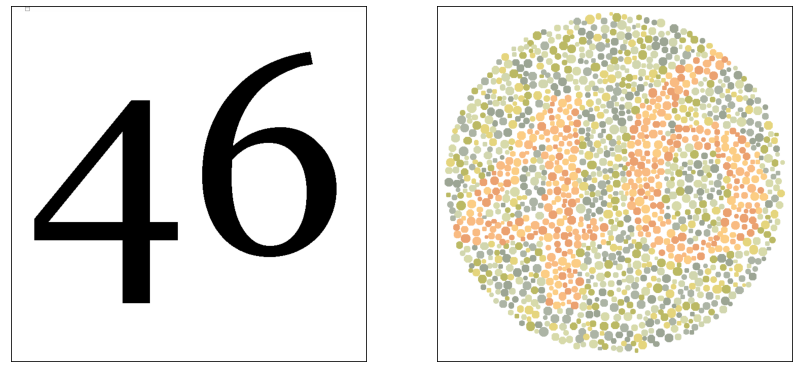

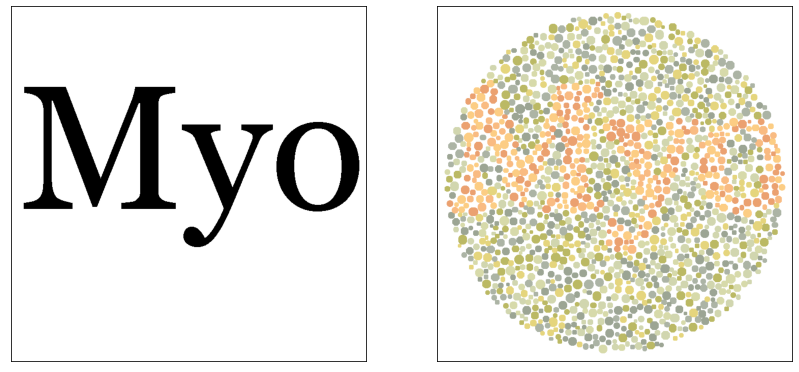

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Generate images 
for file in glob.glob("datasets/ishihara/*-in.png"):
    generate_ish(file)

# Visualize images 
for file in glob.glob("datasets/ishihara/*-in.png"):
    fname = file.split("/")[-1].split("-")[0]
    image_file = mpimg.imread(f"datasets/ishihara/{fname}-in.png")
    test_file = mpimg.imread(f"datasets/ishihara/{fname}-out.png")
    visualize(image_file, test_file)
    
    del image_file, test_file 
    

In [6]:
img = mpimg.imread(f"datasets/ishihara/003-out.png")
img.shape

(700, 700, 3)

<h3>Cluster colors with K-Means</h3>

In [7]:
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import cv2

%matplotlib inline
sns.set_context('talk')
sns.set_style('darkgrid', {'font.sans-serif': ['Iosevka']})

In [8]:
def img_array(path, size, channel, color_space='RGB'):
    '''Get image features/channels'''
    img = cv2.imread(path)
    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)
    img = cv2.cvtColor(img, eval(f"cv2.COLOR_BGR2{color_space}"))
    np_img = img[:, :, channel].reshape(img.shape[0]*img.shape[1], len(channel))
    return img, np_img

def viz_dist(np_img, len_ch=2): 
    '''Features/channels distribution'''
    cols = 2 if len_ch==2 else 1
    _, axis = plt.subplots(1, cols, figsize=(16, 6))
    if len_ch == 2:
        sns.scatterplot(np_img[:,0], np_img[:,1], ax=axis[0])
    
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
    ax_n = 1 if len_ch==2 else 0
    for i in range(len_ch):
        sns.distplot(np_img[:,i], ax=axis[ax_n], color=colors[i])
        
    labels = [f'channel {x}' for x in range(len_ch)]
    plt.legend(labels=labels)
    plt.show()

def viz_cluster(img, np_img, k, color_space, len_ch=2):
    '''Clusters visualization'''
    kmeans = KMeans(n_clusters=k, n_init=40, max_iter=500)
    y_pred = kmeans.fit_predict(np_img)
    
    cols = 2 if len_ch==2 else 1
    fig, axis = plt.subplots(1, cols, figsize=(16, 6))
    
    # Plot clusters only if features/channels is 2
    if len_ch == 2:
        # Cluster datapoints 
        clusters = sns.scatterplot(np_img[:,0], np_img[:,1], ax=axis[0], hue=y_pred, legend='brief')
        # Center datapoints 
        centers = sns.scatterplot(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], ax=axis[0], s=160, color='red')
    
    # Plot image 
    y_pred = y_pred.reshape(img.shape[0], img.shape[1])
    y_pred = y_pred / (k-1)
    
    axis[1].imshow(y_pred)
    axis[1].set_title('')
    axis[1].grid(False)
    axis[1].axes.xaxis.set_visible(False)
    axis[1].axes.yaxis.set_visible(False)
    
#     axis[2].imshow(cv2.cvtColor(img, eval(f"cv2.COLOR_{color_space}2RGB")))
#     axis[2].set_title('')
#     axis[2].grid(False)
#     axis[2].axes.xaxis.set_visible(False)
#     axis[2].axes.yaxis.set_visible(False)
#     plt.grid(False)

    plt.show()


Image: datasets/ishihara/003-out.png
Color space: HSV
Channels: [0, 2]
KMeans: 2


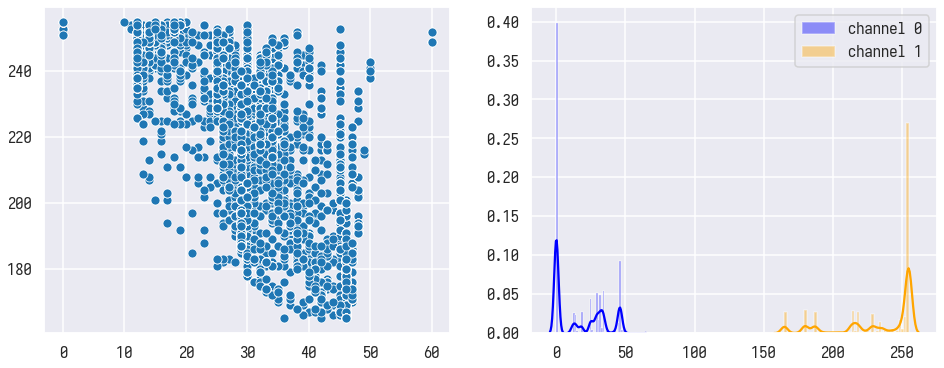

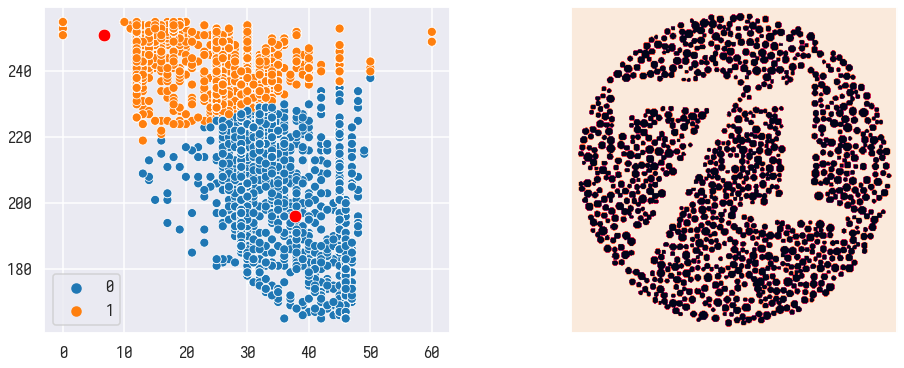

Image: datasets/ishihara/002-out.png
Color space: HSV
Channels: [0, 2]
KMeans: 2


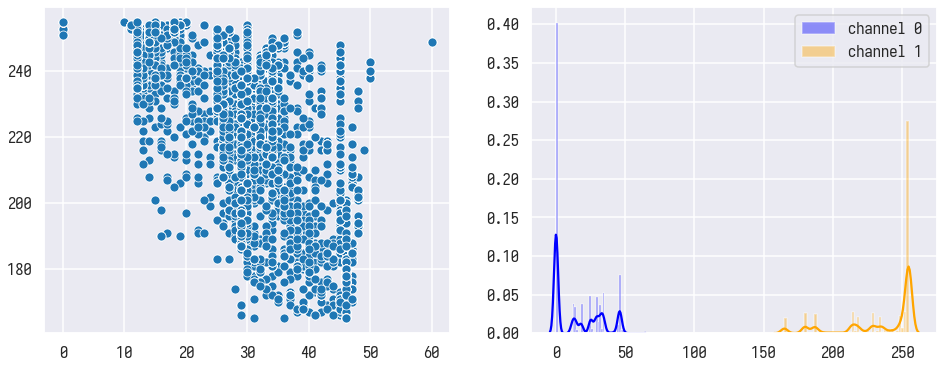

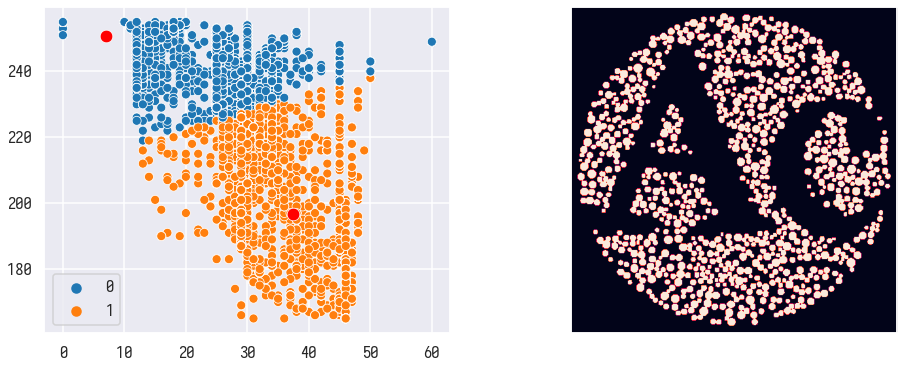

Image: datasets/ishihara/005-out.png
Color space: HSV
Channels: [0, 2]
KMeans: 2


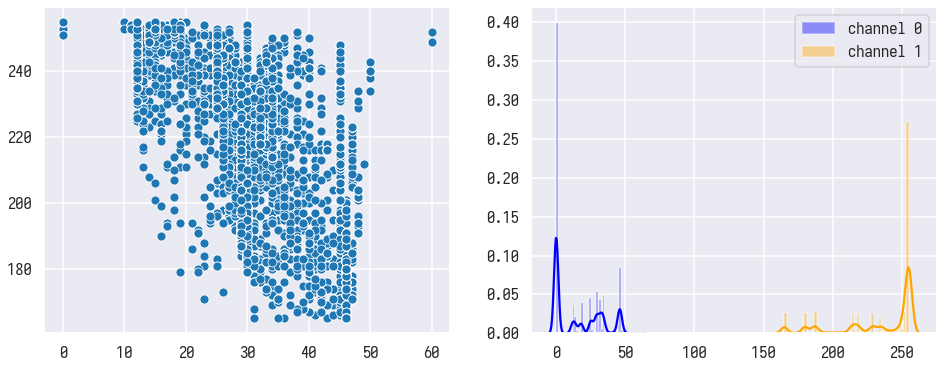

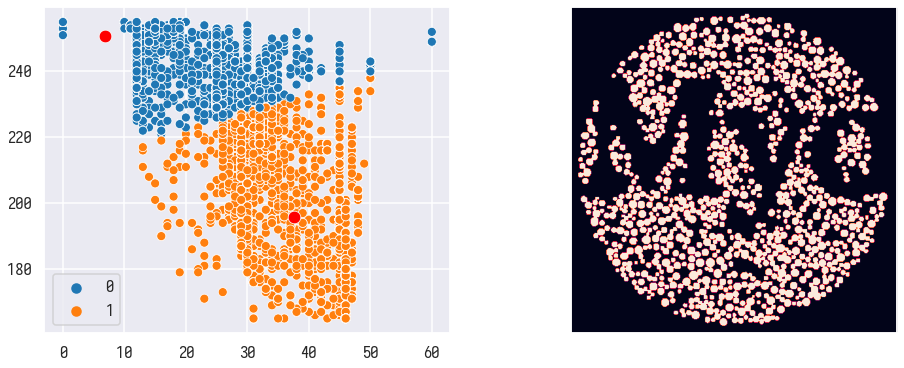

Image: datasets/ishihara/004-out.png
Color space: HSV
Channels: [0, 2]
KMeans: 2


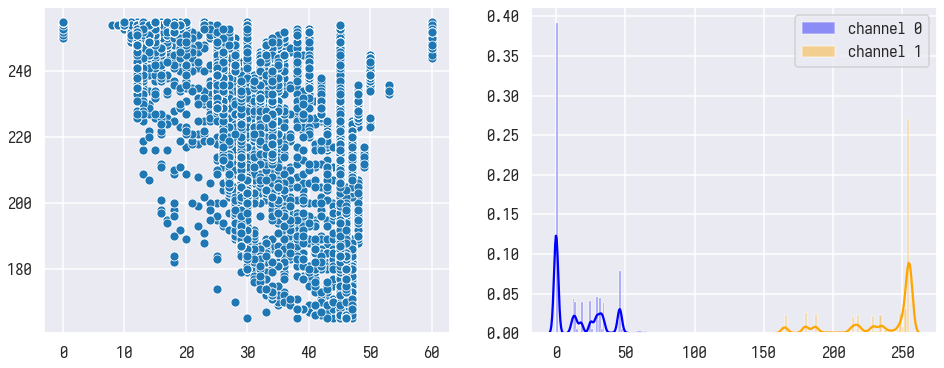

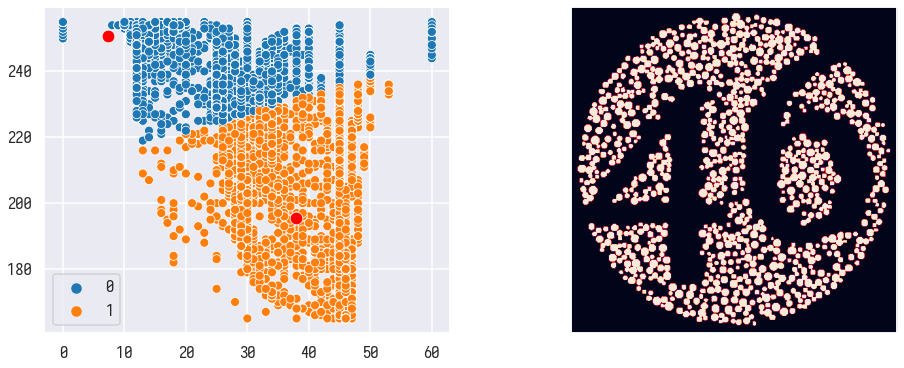

In [9]:
k = 2
COLOR_SPACE = "HSV"
CHANNEL = [0, 2]
IMG_SIZE = 500

# Visualization  
for path in glob.glob("datasets/ishihara/*-out.png"):
    img, np_img = img_array(path, IMG_SIZE, CHANNEL, COLOR_SPACE)
    print(f"Image: {path}")
    print(f"Color space: {COLOR_SPACE}")
    print(f"Channels: {CHANNEL}")
    print(f"KMeans: {k}")
    viz_dist(np_img, len(CHANNEL))
    viz_cluster(img, np_img, k, COLOR_SPACE, len(CHANNEL))